In [1]:
import os
import sys
import pickle
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import seaborn as sns

from sklearn.linear_model import LassoLarsCV


sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils
import plot_style_utils

sys.path.append('../A006_simulated_annealing/')
import A006_common
from unirep import babbler1900 as babbler

sys.path.append('../A003_policy_optimization/')
import A003_common

import A008_common

%reload_ext autoreload
%autoreload 2

In [2]:
np.random.seed(1)
random.seed(1)

In [3]:
inf_brightness_data_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 'A052b_Chip_1_inferred_brightness_v2.csv')

data_io_utils.sync_s3_path_to_local(inf_brightness_data_file, is_single_file=True)

df = pd.read_csv(inf_brightness_data_file)

q = df['id'].apply(lambda s: pd.Series(A008_common.split_seq_id_into_features(s)))
df = df.merge(q, left_index=True, right_index=True)

display(df.head())
print(df.columns)

,id,qfunc,qfunc_rep1,qfunc_rep2,extracted_lib_nt_seq,seq_idx,trajectory_idx,predicted_fitness,ensemble_predicted_fitness,seq,...,DE_Chip_1_GFP_NGS_15,DE_Chip_1_GFP_NGS_16,DE_Chip_1_GFP_NGS_17,DE_Chip_1_GFP_NGS_18,model,ntrain,rep,rep_hash,seq_traj_idx,special_case
0,GFP_SimAnneal-ET_Global_Init_2-0024-04-36079a2...,2.205245,2.335832,2.205245,AAAACAGAGGGTCCTAGAGACGCAACTTATGGTAAAATGACGCCGA...,2719.0,1741.0,9.660326e+07,[-4.4425168e+00 -4.4221644e+00 -5.1892853e+00 ...,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGPRDATYGKMTPKF...,...,0.0,0.0,0.0,0.0,ET_Global_Init_2,24.0,4.0,36079a2c,seq_idx_2719_1741,
1,GFP_SimAnneal-OneHot-0024-04-4279eeb-seq_idx_2...,1.945739,2.011986,1.945739,AAAACAGAGGGTGAAGGTGACGCAACTTATGGTAAACTGAGCCTGA...,2601.0,1191.0,7.883185e-01,[0.73590547 0.76271843 0.77913585 0.75764891 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKTEGEGDATYGKLSLKF...,...,0.0,0.0,0.0,0.0,OneHot,24.0,4.0,4279eeb,seq_idx_2601_1191,
2,GFP_SimAnneal-ET_Random_Init_1-0024-04-1989c09...,2.079981,2.279340,2.079981,AAAATGGAGGGTGAAGGTAATCCTACTGGTGGTAAACTGATTCAGA...,454.0,2029.0,7.540600e-01,[0.7710203 0.7359552 0.6161216 0.77072877 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKMEGEGNPTGGKLIQKF...,...,0.0,0.0,0.0,0.0,ET_Random_Init_1,24.0,4.0,1989c098,seq_idx_454_2029,
3,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.180828,2.236717,2.180828,AAAGGCATAGGTGAAGGTGACGCAACTATGGGTAAACTGACGATTC...,1809.0,1276.0,7.377951e-01,[1.0700963 0.7323966 0.79640985 0.7426758 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKGIGEGDATMGKLTIRF...,...,5.0,0.0,0.0,0.0,ET_Global_Init_1,24.0,4.0,4502d3,seq_idx_1809_1276,
4,GFP_SimAnneal-ET_Global_Init_1-0024-04-4502d3-...,2.670093,2.670093,2.720217,AAAGGCCAAGGTGAAGGTGAAGCAACTTATGGTAAACTGACGCTGA...,317.0,3482.0,7.378049e-01,[0.9574555 0.7345054 0.7397466 0.7718942 0...,MSKGEELFTGVVPILVELDGDVNGHKFSVKGQGEGEATYGKLTLKF...,...,13.0,1.0,1.0,0.0,ET_Global_Init_1,24.0,4.0,4502d3,seq_idx_317_3482,


Index(['id', 'qfunc', 'qfunc_rep1', 'qfunc_rep2', 'extracted_lib_nt_seq',
       'seq_idx', 'trajectory_idx', 'predicted_fitness',
       'ensemble_predicted_fitness', 'seq', 'protein', 'pred_score',
       'lib_aa_seq', 'constant_where_expected', 'successfully_clones',
       'error_message', 'dna_to_order', 'ligated_gene',
       'ligated_gene_translated', 'n_mut_rel_wt', 'oligo_len',
       'DE_Chip_1_GFP_NGS_01', 'DE_Chip_1_GFP_NGS_02', 'DE_Chip_1_GFP_NGS_03',
       'DE_Chip_1_GFP_NGS_04', 'DE_Chip_1_GFP_NGS_05', 'DE_Chip_1_GFP_NGS_06',
       'DE_Chip_1_GFP_NGS_07', 'DE_Chip_1_GFP_NGS_08', 'DE_Chip_1_GFP_NGS_09',
       'DE_Chip_1_GFP_NGS_10', 'DE_Chip_1_GFP_NGS_11', 'DE_Chip_1_GFP_NGS_12',
       'DE_Chip_1_GFP_NGS_13', 'DE_Chip_1_GFP_NGS_14', 'DE_Chip_1_GFP_NGS_15',
       'DE_Chip_1_GFP_NGS_16', 'DE_Chip_1_GFP_NGS_17', 'DE_Chip_1_GFP_NGS_18',
       'model', 'ntrain', 'rep', 'rep_hash', 'seq_traj_idx', 'special_case'],
      dtype='object')


In [4]:
norm_max_val = df[df['id'] == 'avGFP']['qfunc'].iloc[0]
df['qfunc'] = (df['qfunc'] - np.min(df['qfunc'])) #/(norm_max_val - np.min(df['qfunc']))

AVGFP_QFUNC = df[df['id'] == 'avGFP']['qfunc'].iloc[0]
SFGFP_QFUNC = df[df['id'] == 'sfGFP']['qfunc'].iloc[0]

In [5]:
def jitter_by_rep(df_sub, ax=None):
    sns.stripplot(x="rep", y="qfunc", data=df_sub, color='k', size=4, ax=ax, jitter=0.15)
    ax.axhline(AVGFP_QFUNC, color=plot_style_utils.CAT_PALETTE[0], linewidth=3)
    ax.axhline(SFGFP_QFUNC, color=plot_style_utils.CAT_PALETTE[1], linewidth=3)
    ax.set_xticklabels(list('ABCDE'))
    
def jitter_plots_for_all_models_and_reps_at_ntrain(ntrain, models=None, use_small_trust=False):
    if models is None:
        models = ['OneHot', 'ET_Random_Init_1', 'ET_Global_Init_1', 'ET_Global_Init_2']
    
    plt.rcParams.update({'mathtext.default':  'regular' })
    fig, axes = plt.subplots(1,len(models), sharey=True, figsize=(8*(len(models)/4),4))
    
    for i,model in enumerate(models):
        if use_small_trust:
            mask = np.logical_and(
                np.logical_and(df['model'] == model, df['ntrain'] == ntrain), 
                df['special_case'] == 'SmallTrust'
            )
        else:
            mask = np.logical_and(
                np.logical_and(df['model'] == model, df['ntrain'] == ntrain), 
                df['special_case'] != 'SmallTrust'
            )

        df_sub = df[mask]
        hit_rate = 100*np.sum(df_sub['qfunc'] > AVGFP_QFUNC)/df_sub.shape[0]
        
        
        plot_style_utils.prettify_ax(axes[i])
        jitter_by_rep(df_sub, ax=axes[i])
        axes[i].grid(True)

        #plot_title = model + '\n' + 'Avg. Hit Rate = %2.1f%%'%hit_rate # old title
        plot_title = '%2.1f%%'%hit_rate
        axes[i].title.set_text(plot_title)
        axes[i].axhspan(-0.05,0.6,color=[0.8, 0.8, 0.8], alpha=0.5) ## HARD CODED
        axes[i].set_ylim([-0.05, 2.7]) ## HARD CODED
        
        

        if i == 0:
            axes[i].set_ylabel('')            
#             yticklabels = ['$10^{%s}$' % str(t) for t in axes[i].get_yticks()]
#             axes[i].set_yticklabels(yticklabels)
            axes[i].set_xlabel('')
            
        else:
            axes[i].set_ylabel('')
            axes[i].set_xlabel('')
            
    return fig, axes

In [6]:
plot_style_utils.set_pub_plot_context()

## Biological reproducibility (Supp Fig 3)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


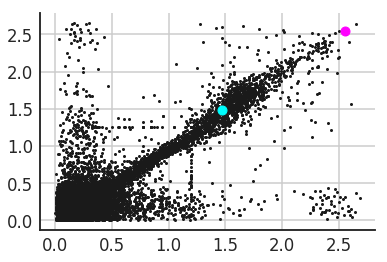

0.8114246896771519


In [7]:
fig = plt.figure()
ax = plt.gca()

avidx = np.argwhere(df['id'] == 'avGFP').reshape(-1)[0]
sfidx = np.argwhere(df['id'] == 'sfGFP').reshape(-1)[0]

plot_style_utils.prettify_ax(ax)
xval = df['qfunc_rep1'] - np.min(df['qfunc_rep1'])
yval = df['qfunc_rep2'] - np.min(df['qfunc_rep2'])

plt.plot(xval, yval, '.k', markersize=4)
plt.plot(xval[avidx], yval[avidx], 'o', color=[0, 1, 1])
plt.plot(xval[sfidx], yval[sfidx], 'o', color=[1, 0, 1])
plt.grid('on')
plt.show()

print(np.corrcoef(xval,yval)[0,1])

plot_style_utils.save_for_pub(fig=fig, path='figures/GFP_bioreproduciblity')

## Performance at N=24 (Fig 2b, top)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


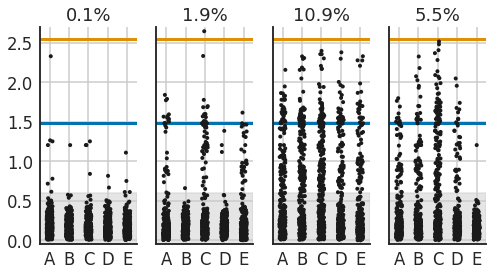

In [8]:
fig, axes = jitter_plots_for_all_models_and_reps_at_ntrain(ntrain=24)
plt.show()

plot_style_utils.save_for_pub(fig=fig, path='figures/jitter_plot_ntrain24')

## Performance at N=96 (Fig 2b, bottom)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


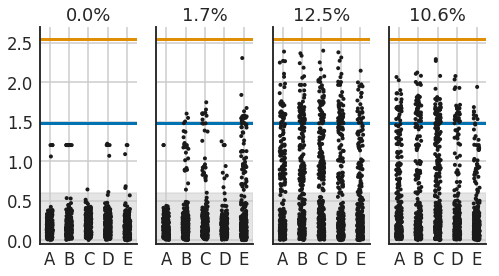

In [9]:
fig, axes = jitter_plots_for_all_models_and_reps_at_ntrain(ntrain=96)
plt.show()

plot_style_utils.save_for_pub(fig=fig, path='figures/jitter_plot_ntrain96')

## Visualize the sequences designed in a small trust radius (Supp Fig 5)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


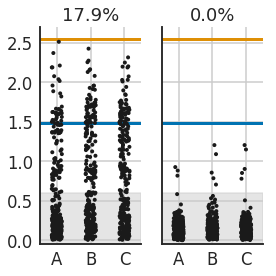

In [10]:
fig, axes = jitter_plots_for_all_models_and_reps_at_ntrain(ntrain=96, 
        models=['ET_Global_Init_1', 'OneHot'], use_small_trust=True)
plt.show()

plot_style_utils.save_for_pub(fig=fig, path='figures/jitter_plot_ntrain96_smalltrust')